In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.models.particle_pair import Particle_Pair
from ATARI.models.experimental_model import Experimental_Model

In [2]:
%matplotlib widget

## Generate synthetic data to play with

In [73]:
### setup the reaction model and sample a resonance
Ta_pair = Particle_Pair()      

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

# setup experimental transmission model
exp_model_T = Experimental_Model()


# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template(
    'template_T_nobg.inp', Ta_pair, exp_model_T, rto)
exp_model_T.template = os.path.realpath('template_T_nobg.inp')



In [87]:
### Generate syndat from 
from ATARI.models.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import syndat, syndatOPT


generative = Transmission_RPI()
reductive = Transmission_RPI()#ks=(0,0),
                             #b0s=(0,0))

synOPT = syndatOPT()

synT = syndat(Ta_pair,
              exp_model_T,
              generative,
              reductive,
              synOPT)

synT.sample(sammyRTO=rto, num_samples=1)

In [88]:
vars(reductive.reduction_parameters)

{'trigo': (9758727, 0),
 'trigs': (18476117, 0),
 'm1': (1, 0.016),
 'm2': (1, 0.008),
 'm3': (1, 0.018),
 'm4': (1, 0.005),
 'ks': (0.563, 0.02402339737495515),
 'ko': (1.471, 0.05576763648617445),
 'b0s': (9.9, 0.1),
 'b0o': (13.4, 0.7),
 'a_b': ([582.7768594580712, 0.05149689096209191],
  [[1143.95753, 0.142659922], [0.142659922, 2.19135003e-05]])}

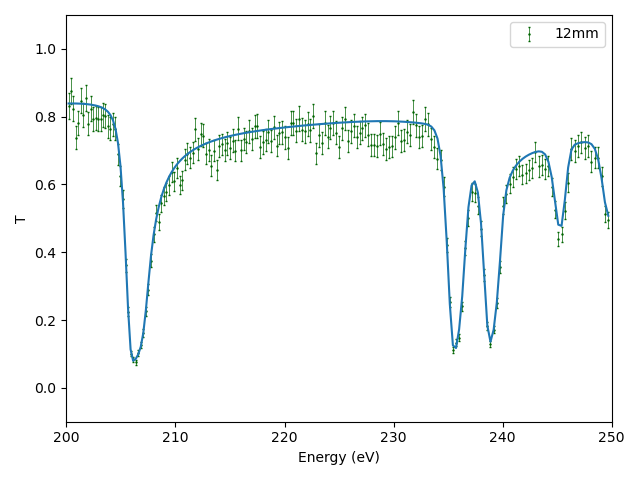

In [89]:
data = synT.datasets[0].pw_reduced


figure()
errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')
plot(data.E, data.true)
ylabel("T")

xlim([200,250])
ylim([-0.1,1.1])
legend()
xlabel('Energy (eV)')
tight_layout()

In [90]:
vars(reductive.reduction_parameters)

{'trigo': (9758727, 0),
 'trigs': (18476117, 0),
 'm1': (1, 0.016),
 'm2': (1, 0.008),
 'm3': (1, 0.018),
 'm4': (1, 0.005),
 'ks': (0.563, 0.02402339737495515),
 'ko': (1.471, 0.05576763648617445),
 'b0s': (9.9, 0.1),
 'b0o': (13.4, 0.7),
 'a_b': ([582.7768594580712, 0.05149689096209191],
  [[1143.95753, 0.142659922], [0.142659922, 2.19135003e-05]])}

New background parameters
(9.9, 0.1)
(0.563, 0.02402339737495515)
328.10337187489404
23.63486654339986
Verify with Scipy fit


(0.1, 10000.0)

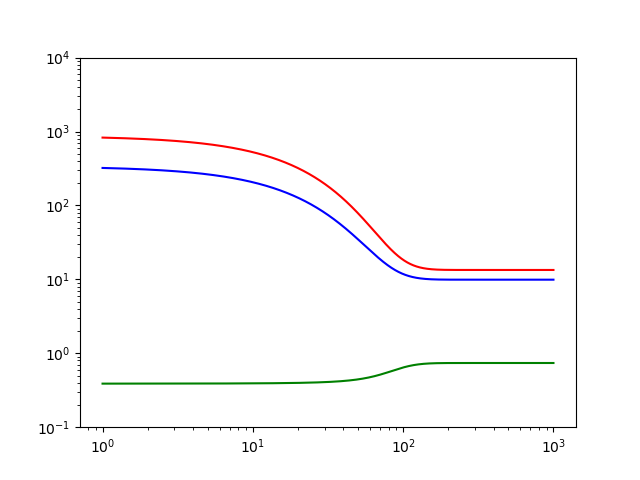

In [95]:
from ATARI.syndat.general_functions import neutron_background_function
from scipy.optimize import curve_fit

### find new background parameters and uncertainty of form A*exp(-b*t) + C rather than ks*A*exp(-b*t)
print("New background parameters")
print(reductive.reduction_parameters.b0s)
print(reductive.reduction_parameters.ks)
print(reductive.reduction_parameters.ks[0]*reductive.reduction_parameters.a_b[0][0])
print(np.sqrt(
    (reductive.reduction_parameters.ks[0]**2 *reductive.reduction_parameters.a_b[1][0][0])
    + (reductive.reduction_parameters.ks[1]*reductive.reduction_parameters.a_b[0][0])**2 
 ) )


print("Verify with Scipy fit")
### Verify with fitting
fake_tof = np.linspace(1,1000,1000000)

Bi = neutron_background_function(fake_tof, reductive.reduction_parameters.a_b[0][0], reductive.reduction_parameters.a_b[0][1])
bgs = reductive.reduction_parameters.ks[0]*Bi+reductive.reduction_parameters.b0s[0]
bgo = reductive.reduction_parameters.ko[0]*Bi+reductive.reduction_parameters.b0o[0]

# def f(t,a,b, b0):
#     return a*np.exp(b*-t) + b0

# popt,pcov = curve_fit(f,fake_tof,bg_wanted)# , p0=[reductive.reduction_parameters.a_b[0][0], reductive.reduction_parameters.a_b[0][1]])
# A,B,b0 = popt[0],popt[1], popt[2]
# fit_func = f(fake_tof,A,B,b0)
# print(reductive.reduction_parameters.a_b[0][0], reductive.reduction_parameters.a_b[0][1])
# print(A, B, b0)

figure()
# plot(data.tof, reductive.reduction_parameters.ko[0]*Bi+reductive.reduction_parameters.b0o[0], 'o')
# plot(fake_tof, bg_wanted, 'g', lw=3)
# plot(fake_tof, fit_func, '--r')
plot(fake_tof, bgs, 'b')
plot(fake_tof, bgo, 'r')
plot(fake_tof, bgs/bgo, 'g')
# plot(fake_tof, fake_tof/)
yscale('log')
xscale('log')
ylim(1e-1, 1e4)

(-0.1, 1.0)

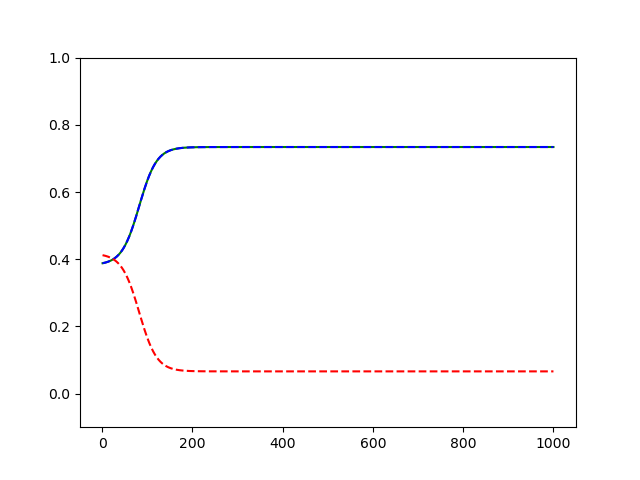

In [126]:
c = np.ones_like(fake_tof)*0.8
C = np.ones_like(fake_tof)

Tbc = (c-bgs)/(C-bgo)
Tnbc = c/C

figure()

plot(fake_tof, Tbc, 'g')
plot(fake_tof, Tnbc - (Tnbc-Tbc), 'b--')
plot(fake_tof, (Tnbc-Tbc), 'r--')
# plot(fake_tof, bgs/np.sum(), 'r-')
ylim(-0.1, 1)

# Fit the data with sammy

In [80]:
importlib.reload(sammy_classes)
importlib.reload(sammy_functions)

<module 'ATARI.sammy_interface.sammy_functions' from '/Users/noahwalton/Documents/GitHub/ATARI/ATARI/sammy_interface/sammy_functions.py'>

In [81]:
rto.bayes=True
rto.get_ECSCM = False

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    Ta_pair.resonance_ladder,
    os.path.realpath('template_T.inp'),
    exp_model_T,
    # energy_grid=exp_model_T.energy_grid
    experimental_data=data
)

sammyINP.initial_parameter_uncertainty=1

# std = 0.01
# data.exp = np.random.default_rng().normal(data.true, std)
# data.exp_unc = std

sammyINP.experimental_data = data
sammyINP.resonance_ladder["varyE"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(Ta_pair.resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)

BACKGround functions
CONST 0   9.9000000 0.1000000 
EXPON 0 0 328.10337 23.634866 0.0514968 0.0046811 

NORMALIZATION AND BACKGROUND ARE NEXT
1.0000000        0.0                                         3
0.0384200

!! when fitting background or normalization, the output lst has an additional column I need to be robust to.

In [82]:
sammyOUT2.chi2_post

249927.0

In [63]:
sammyOUT2.chi2_post

1.09658

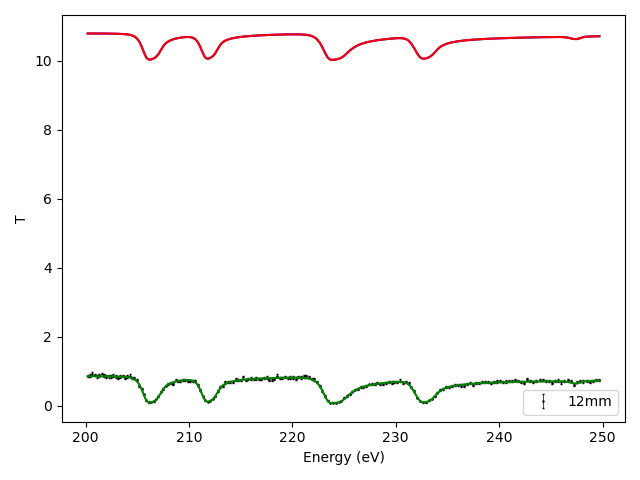

In [84]:

### Plot 
figure()

errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(data.E, data.true, 'g')

plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans, 'b')
plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans_bayes, 'r')
# plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# sammyOUT_old = copy(sammyOUT2)

# x = sammyOUT2.est_df.E
# y = sammyOUT2.est_df.theo
# y_err=  sammyOUT2.est_df.theo_unc #
# # y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
# fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
# plot(x, y, 'r')

ylabel("T")

# xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


# figure()
# imshow(sammyOUT2.ECSCM)
# colorbar()

In [14]:
# samples = 100

# cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
# cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

# for i in range(samples):
#     # synT.run(sammyOUT.pw)
#     data.exp = np.random.default_rng().normal(synT.data.true, std)
#     data.exp_unc = std
#     sammyINP.experimental_data = synT.data
#     sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#     residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#     cov_true += residual.T@residual
#     cov_est += sammyOUT2.ECSCM
#     # true.append(cov_true)
#     # est.append(cov_est)

In [15]:
# iest = 0
# fig, axes = subplots(1,2, figsize=(10,4))
# # im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# # im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
# im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 8e-5))
# im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 8e-5))
# axes[0].set_title("empirical")

# axes[1].set_title("estimated")
# # for ax in axes:
# colorbar(im1)

# colorbar(im2)

# print("Empirical Fnorm")
# print(np.linalg.norm(cov_true/(samples), ord='fro'))
# print("Estimated Fnorm")
# print(np.linalg.norm(cov_est/(samples-1), ord='fro'))

In [16]:
# ### Plot 
# figure()

# # errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
# #                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# # plot(synT.data.E, synT.data.true, 'g')
# plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
# plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


# xlim([200,225])
# # ylim([-0.1,1.1])
# legend()

# xlabel('Energy (eV)')
# tight_layout()

In [17]:
# # result_dict = {}
# # stds = [0.1, 0.01, 0.001, 0.0001]
# stds = [0.00001, 0.05]

# for istd in stds:
#     samples = 1000
#     cov_true = np.zeros([len(sammyOUT2.pw), len(sammyOUT2.pw)])
#     cov_est = np.zeros([len(sammyOUT2.est_df), len(sammyOUT2.est_df)])
#     for i in range(samples):
#         # synT.run(sammyOUT.pw)
#         synT.data.exp = np.random.default_rng().normal(synT.data.true, istd)
#         synT.data.exp_unc = istd
#         sammyINP.experimental_data = synT.data
#         sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#         residual = np.atleast_2d(
#             sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#         cov_true += residual.T@residual
#         cov_est += sammyOUT2.ECSCM
        
#     result_dict[istd] = [cov_true, cov_est]

In [18]:
# stds = [1.0, 0.1, 0.05, 0.01, 0.001, 0.0001]
# true= []
# est = []

# for istd in stds:
#     res = result_dict[istd]
#     cov_true = res[0]
#     cov_est = res[1]
#     print(istd)
#     # print("Empirical Fnorm: ", np.linalg.norm(cov_true/(samples), ord='fro'))
#     # print("Estimated Fnorm: ", np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     # true.append(np.linalg.norm(cov_true/(samples), ord='fro'))
#     # est.append(np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     print("Empirical Fnorm: ", np.sum(np.diag(cov_true)**2/(samples)))
#     print("Estimated Fnorm: ", np.sum(np.diag(cov_est)**2/(samples-1)))
#     true.append(np.sum(np.diag(cov_true)**2/(samples)))
#     est.append(np.sum(np.diag(cov_est)**2/(samples-1)))

In [19]:
# figure()
# plot(stds, true, '.', label='Empirical')
# plot(stds, est, '.r', label='Estimate')
# xscale("log")
# yscale("log")
# legend()
# # ylabel("Noise Level")
# xlabel("Noise Level")